In [64]:
import json
import logging
from pathlib import Path
import yaml
import logging
import time

from rich.console import Console
from rich.panel import Panel

In [65]:
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend

from docling.document_converter import (
    DocumentConverter,
    PdfFormatOption,
    WordFormatOption,
)

from docling.pipeline.simple_pipeline import SimplePipeline
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline
from docling.pipeline.vlm_pipeline import VlmPipeline

from docling.datamodel.base_models import InputFormat
from docling.datamodel import vlm_model_specs
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
    PdfPipelineOptions,
)

from docling_core.types.doc import ImageRefMode, PictureItem, TableItem

from docling_core.transforms.serializer.html import HTMLDocSerializer
from docling_core.transforms.serializer.markdown import MarkdownDocSerializer

from docling.chunking import HybridChunker


In [66]:
_log = logging.getLogger(__name__)

# Simple Conversion

INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for SimplePipeline with options hash 4cc01982ae99b46a2a63fcda46c47c35
INFO:docling.pipeline.base_pipeline:Processing document 2.docx
INFO:docling.document_converter:Finished converting document 2.docx in 0.23 sec.


{
    "schema_name": "DoclingDocument",
    "version": "1.5.0",
    "name": "2",
    "origin": {
        "mimetype": "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
        "binary_hash": 16362330361278679064,
        "filename": "2.docx"
    },
    "furniture": {
        "self_ref": "#/furniture",
        "children": [],
        "content_layer": "furniture",
        "name": "_root_",
        "label": "unspecified"
    },
    "body": {
        "self_ref": "#/body",
        "children": [
            {
                "$ref": "#/groups/0"
            }
        ],
        "content_layer": "body",
        "name": "_root_",
        "label": "unspecified"
    },
    "groups": [
        {
            "self_ref": "#/groups/0",
            "parent": {
                "$ref": "#/body"
            },
            "children": [
                {
                    "$ref": "#/texts/0"
                }
            ],
            "content_layer": "body",
            "name"
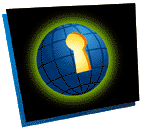
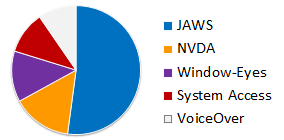

In [68]:
def SimpleConversion():
    source = Path("DOCX Files/2.docx")

    converter = DocumentConverter()
    doc = converter.convert(source).document

    # print(doc.export_to_markdown())

    # Export to json
    json_output = json.dumps(doc.export_to_dict(), indent=4)
    print(json_output)

SimpleConversion()


# Multi-Format Conversion

In [69]:
def MultiFormat():
    input_paths = [
        Path("Master Approval Letter.docx"),
        Path("DOCX Files/2.docx"),
    ]

    ## for defaults use:
    # doc_converter = DocumentConverter()

    ## to customize use:

    doc_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.DOCX,       
            ],  # whitelist formats, non-matching files are ignored.
            format_options={
                InputFormat.PDF: PdfFormatOption(
                    pipeline_cls=StandardPdfPipeline, backend=PyPdfiumDocumentBackend
                ),
                InputFormat.DOCX: WordFormatOption(
                    pipeline_cls=SimplePipeline  # , backend=MsWordDocumentBackend
                ),
            },
        )
    )

    conv_results = doc_converter.convert_all(input_paths)

    for res in conv_results:
        out_path = Path("Extracted_Content")
        print(
            f"Document {res.input.file.name} converted."
            f"\nSaved markdown output to: {out_path!s}"
        )
        _log.debug(res.document._export_to_indented_text(max_text_len=16))
        # Export Docling document format to markdowndoc:

        with (out_path / f"{res.input.file.stem}.json").open("w") as fp:
            fp.write(json.dumps(res.document.export_to_dict(), indent=4))

MultiFormat()

INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for SimplePipeline with options hash 4cc01982ae99b46a2a63fcda46c47c35
INFO:docling.pipeline.base_pipeline:Processing document Master Approval Letter.docx
INFO:docling.document_converter:Finished converting document Master Approval Letter.docx in 0.34 sec.
INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.pipeline.base_pipeline:Processing document 2.docx


Document Master Approval Letter.docx converted.
Saved markdown output to: Extracted_Content


INFO:docling.document_converter:Finished converting document 2.docx in 0.31 sec.


Document 2.docx converted.
Saved markdown output to: Extracted_Content


# Figure export

In [70]:
IMAGE_RESOLUTION_SCALE = 2.0

def FigureExport():
    logging.basicConfig(level=logging.INFO)

    data_folder = Path("DOCX Files/")
    input_doc_path = data_folder / "2.docx"
    output_dir = Path("Extracted_Content")

    # Important: For operating with page images, we must keep them, otherwise the DocumentConverter
    # will destroy them for cleaning up memory.
    # This is done by setting PdfPipelineOptions.images_scale, which also defines the scale of images.
    # scale=1 correspond of a standard 72 DPI image
    # The PdfPipelineOptions.generate_* are the selectors for the document elements which will be enriched
    # with the image field
    pipeline_options = PdfPipelineOptions()
    pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
    pipeline_options.generate_page_images = True
    pipeline_options.generate_picture_images = True

    doc_converter = DocumentConverter(
        format_options={
            InputFormat.DOCX: WordFormatOption(pipeline_options=pipeline_options)
        }
    )

    start_time = time.time()

    conv_res = doc_converter.convert(input_doc_path)

    output_dir.mkdir(parents=True, exist_ok=True)
    doc_filename = conv_res.input.file.stem

    # Save page images
    for page_no, page in conv_res.document.pages.items():
        page_no = page.page_no
        page_image_filename = output_dir / f"{doc_filename}-{page_no}.png"
        with page_image_filename.open("wb") as fp:
            page.image.pil_image.save(fp, format="PNG")

    # Save images of figures and tables
    table_counter = 0
    picture_counter = 0
    for element, _level in conv_res.document.iterate_items():
        if isinstance(element, TableItem):
            table_counter += 1
            element_image = element.get_image(conv_res.document)
            if element_image:  # Check if the image exists
                element_image_filename = (
                    output_dir / f"{doc_filename}-table-{table_counter}.png"
                )
                with element_image_filename.open("wb") as fp:
                    element_image.save(fp, "PNG")

        if isinstance(element, PictureItem):
            picture_counter += 1
            element_image = element.get_image(conv_res.document)
            if element_image:  # Check if the image exists
                element_image_filename = (
                    output_dir / f"{doc_filename}-picture-{picture_counter}.png"
                )
                with element_image_filename.open("wb") as fp:
                    element_image.save(fp, "PNG")

    # Save markdown with embedded pictures
    md_filename = output_dir / f"{doc_filename}-with-images.md"
    conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.EMBEDDED)

    # Save markdown with externally referenced pictures
    md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
    conv_res.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

    # Save HTML with externally referenced pictures
    html_filename = output_dir / f"{doc_filename}-with-image-refs.html"
    conv_res.document.save_as_html(html_filename, image_mode=ImageRefMode.REFERENCED)

    end_time = time.time() - start_time

    _log.info(f"Document converted and figures exported in {end_time:.2f} seconds.")

FigureExport()

INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for SimplePipeline with options hash 45e823ad9aa4b6fa53c56667a4a8e97c
INFO:docling.pipeline.base_pipeline:Processing document 2.docx


INFO:docling.document_converter:Finished converting document 2.docx in 0.23 sec.
INFO:__main__:Document converted and figures exported in 0.44 seconds.


# Multimodal Export

# Serialization

In [71]:
console = Console(width=210)  # for preventing Markdown table wrapped rendering
DOC_SOURCE = "DOCX Files/2.docx"

def print_in_console(text):
    console.print(Panel(text))

converter = DocumentConverter()
doc = converter.convert(source=DOC_SOURCE).document

# Serialize to HTML
# serializer = HTMLDocSerializer(doc=doc)

# Serialize to Markdown
serializer = MarkdownDocSerializer(doc=doc)
ser_result = serializer.serialize()
ser_text = ser_result.text

# we here only print an excerpt to keep the output brief:
print_in_console(ser_text)

INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]


INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for SimplePipeline with options hash 4cc01982ae99b46a2a63fcda46c47c35
INFO:docling.pipeline.base_pipeline:Processing document 2.docx
INFO:docling.document_converter:Finished converting document 2.docx in 0.28 sec.


╭────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ## Sample Document                                                                                                                                                                                             │
│                                                                                                                                                                                                                │
│ This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen        │
│ readers.                                                                                                                                                                                                       │
│                                                                                                                                                                                                                │
│ ### Headings                                                                                                                                                                                                   │
│                                                                                                                                                                                                                │
│ There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables        │
│ section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headings.                                                                                                        │
│                                                                                                                                                                                                                │
│ ### Lists                                                                                                                                                                                                      │
│                                                                                                                                                                                                                │
│ The following outline of the sections of this document is an ordered (numbered) list with six items. The fifth item, "Tables," contains a nested unordered (bulleted) list with two items.                     │
│                                                                                                                                                                                                                │
│ - Headings                                                                                                                                                                                                     │
│ - Lists                                                                                                                                                                                                        │
│ - Links                                                                                                                                                                                                        │
│ - Images                                                                                                                                                                                                

# Hybrid Chunking
### Can also be used with other Tokenizers like OpenAI, Hugging Face etc.
#### https://docling-project.github.io/docling/examples/advanced_chunking_and_serialization/

In [72]:
doc = DocumentConverter().convert(source=DOC_SOURCE).document

chunker = HybridChunker()
chunk_iter = chunker.chunk(dl_doc=doc)

for i, chunk in enumerate(chunk_iter):
    print(f"=== {i} ===")
    print(f"chunk.text:\n{f'{chunk.text[:300]}…'!r}")

    enriched_text = chunker.contextualize(chunk=chunk)
    print(f"chunker.contextualize(chunk):\n{f'{enriched_text[:300]}…'!r}")

    print()

INFO:docling.datamodel.document:detected formats: [<InputFormat.DOCX: 'docx'>]
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for SimplePipeline with options hash 4cc01982ae99b46a2a63fcda46c47c35
INFO:docling.pipeline.base_pipeline:Processing document 2.docx
INFO:docling.document_converter:Finished converting document 2.docx in 0.25 sec.


=== 0 ===
chunk.text:
'This document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.…'
chunker.contextualize(chunk):
'Sample Document\nThis document was created using accessibility techniques for headings, lists, image alternate text, tables, and columns. It should be completely accessible using assistive technologies such as screen readers.…'

=== 1 ===
chunk.text:
'There are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main section headings, such as "Headings" and "Lists" are level 2 headings. The Tables section contains two sub-headings, "Simple Table" and "Complex Table," which are both level 3 headin…'
chunker.contextualize(chunk):
'Sample Document\nHeadings\nThere are eight section headings in this document. At the beginning, "Sample Document" is a level 1 heading. The main sect